In [13]:
import importlib
import dataset

importlib.reload(dataset)
from dataset import (
    CropSample,
    FixChannelDimension,
    PadSample,
    ResizeSample,
    NormalizeVolume,
    GreyToRGB,
    ChannelSwitchBST,
    FixChannelDimension,
)


import os
import os.path as op
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as tfms
from glob import glob
import logging
from dataset import (
    CropSample,
    PadSample,
    ResizeSample,
    NormalizeVolume,
    GreyToRGB,
    ChannelSwitchBST,
    FixChannelDimension,
)
from PIL import Image
import re
import random

# Ignore warnings
# import warnings

# warnings.filterwarnings("ignore")

plt.ion()  # interactive mode


# install pytorch correctly
# https://discuss.pytorch.org/t/torch-cuda-is-not-available/74845/11
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
logging.basicConfig(
    level=logging.INFO,
)
# install cuda driver ubuntu
# https://ubuntu.com/server/docs/nvidia-drivers-installation

cuda


In [7]:
# https://pytorch.org/docs/stable/cuda.html
# torch.cuda.is_initialized()

if torch.cuda.is_available():
    current_device = torch.cuda.current_device()
    print(f"Current cuda device: {torch.cuda.get_device_name(current_device)}")

Current cuda device: NVIDIA RTX A2000


In [8]:
# script for segmentation
# https://github.com/mateuszbuda/brain-segmentation-pytorch

In [33]:
class DataloaderImg(Dataset):
    """
    Dataset class for loading nifti files and masks for electrode extraction
    from a directory. The directory must have the following structure:

    root_dir
    ├── sub-01
    │   ├── ses-01
    │   │   ├── run-01
    │   │   │   ├── petra_.nii.gz
    │   │   │   ├── cylinder_plus_plug_ROI_FN.nii.gz
    │   │   ├── run-02
    │   │   │   ├── petra_.nii.gz
    │   │   │   ├── cylinder_plus_plug_ROI_FN.nii.gz
    ├── ses-02
    │   │   ├── run-01
    │   │   │   ├── petra_.nii.gz
    │   │   │   ├── cylinder_plus_plug_ROI_FN.nii.gz
    │   │   ├── run-02
    │   │   │   ├── petra_.nii.gz
    │   │   │   ├── cylinder_plus_plug_ROI_FN.nii.gz

    ...

    Parameters
    ----------
    root_dir : str
        The root directory of the dataset
    transforms : list[object], optional
        List of transforms to apply to the data, by default [CropSample(), PadSample(), ResizeSample(), NormalizeVolume()]
    subset : str, optional
        The subset of the dataset to load, by default "train"
    random_sampling : bool, optional
        Whether to randomly sample the dataset, by default True
    validation_cases : int, optional
        The number of cases to use for validation, by default 10
    seed : int, optional
        The random seed to use for sampling, by default 42. Only used if random_sampling is True
        Should be the same for train and validation dataset.


    Returns
    -------
    volume : np.ndarray
        The volume of the MRI scan
    mask : np.ndarray
        The mask of the MRI scan

    """

    def __init__(
        self,
        root_dir: str,
        transforms: list[object]
        | None = [
            # GreyToRGB(),
            # ChannelSwitchBST(),
            CropSample(),
            PadSample(),
            ResizeSample(),
            NormalizeVolume(),
            # FixChannelDimension(),
        ],
        subset: str = "train",
        random_sampling: bool = True,
        validation_cases: int = 10,
        seed: int = 42,
    ):
        if subset not in ["train", "validation", "all"]:
            raise ValueError("subset must be one of train, validation, or all")

        self.root_dir = root_dir
        self.transforms = tfms.Compose(transforms)
        self.subject_pattern = op.join(
            self.root_dir,
            "sub-*",
            "electrode_extraction",
            "ses-*",
            "run-*",
        )
        self.volume = glob(op.join(self.subject_pattern, "petra_.nii.gz"))
        self.mask = glob(
            op.join(self.subject_pattern, "cylinder_plus_plug_ROI_FN.nii.gz")
        )  # TODO: change file name

        if not subset == "all":
            random.seed(seed)
            validation_volumes = random.sample(self.volume, k=validation_cases)
            if subset == "validation":
                self.volume = validation_volumes
            else:
                self.volume = sorted(
                    list(set(self.volume).difference(validation_volumes))
                )

        self.sub_ses_run_idx = [
            "_".join(re.findall(r"(sub-[0-9]+|ses-[0-9]|run-[0-9]+)", x))
            for x in self.volume
        ]
        print(self.sub_ses_run_idx)

        self.random_sampling = random_sampling

        # TODO: create a sub index

    def __len__(self):
        # TODO: change so that it returns the actual number of files not number of subjects
        return len(self.volume)

    def __getitem__(self, idx):
        volume_name = self.volume[idx]
        mask_name = self.mask[idx]
        volume = nib.load(volume_name)
        # change to numpy
        volume = np.asarray(volume.dataobj, dtype=np.float32)
        # change to PIL

        print(f"volume Size: {volume.size}")

        mask = nib.load(mask_name)
        # change to numpy
        mask = np.asarray(mask.dataobj, dtype=np.float32)
        # change to PIL
        # mask = Image.fromarray(mask.astype("uint8"), "L")

        print(f"mask Size: {mask.size}")

        if self.transforms is not None:
            volume, mask = self.transforms((volume, mask))

        if self.random_sampling:
            slice_weights = mask.sum(axis=(1, 2))
            slice_weights = (
                slice_weights + (slice_weights.sum() * 0.1 / len(slice_weights))
            ) / (slice_weights.sum() * 1.1)

            slice_n = np.random.choice(np.arange(len(slice_weights)), p=slice_weights)

        volume = volume[slice_n]
        mask = mask[slice_n]

        image_tensor = torch.from_numpy(volume)
        mask_tensor = torch.from_numpy(mask)

        return image_tensor, mask_tensor


# help in loading images
# https://discuss.pytorch.org/t/how-to-load-all-the-nii-from-the-directory-without-augmentation-using-pytorch-dataloader/60938/3
root_dir = "/media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train"  #!NOTE: delete "/train" for all subjects

# full_dataset = Dataloder_img('C:/Users/Ali ktk/.spyder-py3/dataloader/data/train/1', 'C:/Users/Ali ktk/.spyder-py3/dataloader/data/train/1/ADNI_136_S_0300_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080529142830882_S50401_I107759.nii' ,tfms.Compose([tfms.RandomRotation(180).tfms.ToTensor()]))
train_dataset = DataloaderImg(
    root_dir,
    subset="train",
    validation_cases=2,
)
validation_dataset = DataloaderImg(
    root_dir,
    subset="validation",
    validation_cases=2,
)


['sub-010_ses-1_run-01', 'sub-010_ses-2_run-02', 'sub-010_ses-3_run-02', 'sub-010_ses-4_run-01', 'sub-010_ses-4_run-02']
['sub-010_ses-2_run-01', 'sub-010_ses-3_run-01']


In [36]:
loader = DataLoader(train_dataset, batch_size=2, shuffle=True)

test_img, test_mask = next(iter(loader))

print(f"test_img shape: {test_img.shape}")

plt.imshow(test_img[0])

In [7]:
img = nib.load(
    "/media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train/sub-010/electrode_extraction/ses-1/run-01/petra_.nii.gz"
)
volume = np.array(img.dataobj, dtype=np.float32)
mask = nib.load(
    "/media/MeMoSLAP_Subjects/derivatives/automated_electrode_extraction/train/sub-010/electrode_extraction/ses-1/run-01/cylinder_plus_plug_ROI_FN.nii.gz"
)
mask = np.array(mask.dataobj, dtype=np.uint8)

In [10]:
w, h, d =  volume.shape
volume += np.abs(np.min(volume))
volume_max = np.max(volume)
if volume_max > 0:
    volume /= volume_max 
ret = np.empty((w, h, d, 3), dtype=np.uint8)
ret[:, :, :, 2] = ret[:, :, :, 1] = ret[:, :, :, 0] = volume * 255
volume = ret

In [12]:

def min_max_projection(axis: int):
    
    axis = [i for i in range(4) if i != axis]
    axis = tuple(axis)
    projection = np.max(volume, axis=axis)
    non_zero = np.nonzero(projection)
    return np.min(non_zero), np.max(non_zero) + 1 
z_min, z_max = min_max_projection(0)
y_min, y_max = min_max_projection(1)
x_min, x_max = min_max_projection(2)
volume = volume[z_min:z_max, y_min:y_max, x_min:x_max, :]
mask = mask[z_min:z_max, y_min:y_max, x_min:x_max]

In [17]:
a = volume.shape[1]
b = volume.shape[2]

if a != b:
    diff = (max(a, b) - min(a, b)) / 2.0
    padding_insert = (
        int(np.floor(diff)),
        int(np.ceil(diff)),
    )
    if a > b:
        padding = ((0, 0), (0, 0), padding_insert)
    else:
        padding = ((0, 0), padding_insert, (0, 0))
    mask = np.pad(mask, padding, mode="constant", constant_values=0)
    padding = padding + ((0, 0),)
    volume = np.pad(volume, padding, mode="constant", constant_values=0)


In [18]:
volume.shape

(224, 288, 288, 3)

In [19]:
mask.shape

(224, 288, 288)

In [21]:
from skimage.transform import resize
v_shape = volume.shape
size = 512
out_shape = (v_shape[0], size, size)
mask = resize(
    mask,
    output_shape=out_shape,
    order=0,
    mode="constant",
    cval=0,
    anti_aliasing=False,
)
out_shape = out_shape + (v_shape[3],)
volume = resize(
    volume,
    output_shape=out_shape,
    order=2,
    mode="constant",
    cval=0,
    anti_aliasing=False,
)

In [22]:
volume.shape

(224, 512, 512, 3)

In [23]:
mask.shape

(224, 512, 512)

In [25]:
from skimage.exposure import rescale_intensity
p10 = np.percentile(volume, 10)
p99 = np.percentile(volume, 99)
volume = rescale_intensity(volume, in_range=(p10, p99))
m = np.mean(volume, axis=(0, 1, 2))
s = np.std(volume, axis=(0, 1, 2))
volume = (volume - m) / s

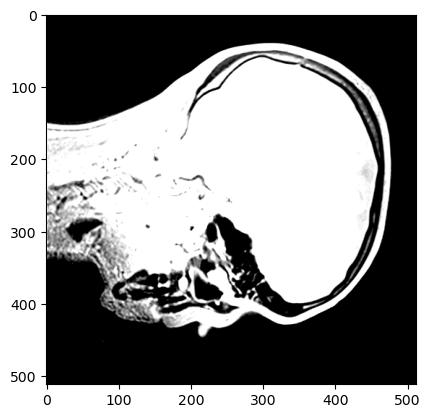

In [27]:
plt.imshow(volume[100])

In [31]:
z_projection2 = np.max(volume, axis = (1, 2))

In [32]:
np.all(z_projection == z_projection2)

True

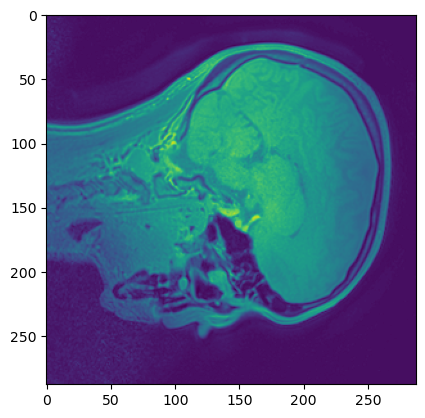

In [9]:
plt.imshow(img[100])

In [7]:
class BrainSegmentationDataset(Dataset):
    """Brain MRI dataset for FLAIR abnormality segmentation"""

    in_channels = 3
    out_channels = 1

    def __init__(
        self,
        images_dir,
        transform=None,
        image_size=256,
        subset="train",
        random_sampling=True,
        validation_cases=40,
        seed=42,  # ???
    ):
        assert subset in ["all", "train", "validation"]

        # read images
        volumes = {}
        masks = {}
        print("reading {} images...".format(subset))
        for dirpath, dirnames, filenames in os.walk(images_dir):
            image_slices = []
            mask_slices = []
            for filename in sorted(
                filter(lambda f: ".tif" in f, filenames),
                key=lambda x: int(x.split(".")[-2].split("_")[4]),
            ):
                filepath = os.path.join(dirpath, filename)
                if "mask" in filename:
                    mask_slices.append(imread(filepath, as_gray=True))
                else:
                    image_slices.append(imread(filepath))
            if len(image_slices) > 0:
                patient_id = dirpath.split("/")[-1]
                volumes[patient_id] = np.array(image_slices[1:-1])
                masks[patient_id] = np.array(mask_slices[1:-1])

        self.patients = sorted(volumes)

        # select cases to subset
        if not subset == "all":
            random.seed(seed)
            validation_patients = random.sample(self.patients, k=validation_cases)
            if subset == "validation":
                self.patients = validation_patients
            else:
                self.patients = sorted(
                    list(set(self.patients).difference(validation_patients))
                )

        print("preprocessing {} volumes...".format(subset))
        # create list of tuples (volume, mask)
        self.volumes = [(volumes[k], masks[k]) for k in self.patients]

        print("cropping {} volumes...".format(subset))
        # crop to smallest enclosing volume
        self.volumes = [crop_sample(v) for v in self.volumes]

        print("padding {} volumes...".format(subset))
        # pad to square
        self.volumes = [pad_sample(v) for v in self.volumes]

        print("resizing {} volumes...".format(subset))
        # resize
        self.volumes = [resize_sample(v, size=image_size) for v in self.volumes]

        print("normalizing {} volumes...".format(subset))
        # normalize channel-wise
        self.volumes = [(normalize_volume(v), m) for v, m in self.volumes]

        # probabilities for sampling slices based on masks
        self.slice_weights = [m.sum(axis=-1).sum(axis=-1) for v, m in self.volumes]
        self.slice_weights = [
            (s + (s.sum() * 0.1 / len(s))) / (s.sum() * 1.1) for s in self.slice_weights
        ]

        # add channel dimension to masks
        self.volumes = [(v, m[..., np.newaxis]) for (v, m) in self.volumes]

        print("done creating {} dataset".format(subset))

        # create global index for patient and slice (idx -> (p_idx, s_idx))
        num_slices = [v.shape[0] for v, m in self.volumes]
        self.patient_slice_index = list(
            zip(
                sum([[i] * num_slices[i] for i in range(len(num_slices))], []),
                sum([list(range(x)) for x in num_slices], []),
            )
        )

        self.random_sampling = random_sampling

        self.transform = transform

    def __len__(self):
        return len(self.patient_slice_index)

    def __getitem__(self, idx):
        patient = self.patient_slice_index[idx][0]
        slice_n = self.patient_slice_index[idx][1]

        if self.random_sampling:
            patient = np.random.randint(len(self.volumes))
            slice_n = np.random.choice(
                range(self.volumes[patient][0].shape[0]), p=self.slice_weights[patient]
            )

        v, m = self.volumes[patient]
        image = v[slice_n]
        mask = m[slice_n]

        if self.transform is not None:
            image, mask = self.transform((image, mask))

        # fix dimensions (C, H, W)
        image = image.transpose(2, 0, 1)
        mask = mask.transpose(2, 0, 1)

        image_tensor = torch.from_numpy(image.astype(np.float32))
        mask_tensor = torch.from_numpy(mask.astype(np.float32))

        # return tensors
        return image_tensor, mask_tensor